In [11]:
import keras, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
#keras.backend.clear_session()

In [1]:
# fit a cnn on the fashion mnist dataset
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
# load dataset
(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))
# convert from integers to floats
trainX, testX = trainX.astype('float32'), testX.astype('float32')
# normalize to range 0-1
trainX,testX  = trainX / 255.0, testX / 255.0

# one hot encode target values
trainY, testY = to_categorical(trainY), to_categorical(testY)      #only need this if using labels

# model I found on the internet

# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
# model.add(MaxPooling2D())
# model.add(Flatten())
# model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
# model.add(Dense(10, activation='softmax'))

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# # fit model
# model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=2)
# # evaluate model
# loss, acc = model.evaluate(testX, testY, verbose=0)
# print(loss, acc)

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, InputLayer

#this is the only one that works but terrible accuracy (only 50%)

def autoencoder_two(img_size):
    stacked_encoder = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[img_size[0], img_size[1],1]),
        keras.layers.Dense(200, activation="selu"),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(30, activation="selu"),])

    stacked_decoder = keras.models.Sequential([
        keras.layers.Dense(100, activation="selu", input_shape=[30]),
        keras.layers.Dense(200, activation="selu", input_shape=[100]),
        keras.layers.Dense(img_size[0] * img_size[1], activation="sigmoid"),
        keras.layers.Reshape([img_size[0], img_size[1],1])])
    
    return stacked_encoder, stacked_decoder

In [14]:
#doesn't work because of different dimensions

def autoencoder_three(img_size):
    encoder = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', 
                     input_shape=(img_size[0], img_size[1], 1)),
        MaxPooling2D(2)
    ])
    
    decoder = Sequential([
        Flatten(),
        Dense(100, activation='relu', kernel_initializer='he_uniform'),
        Dense(10, activation='softmax')
    ])

    return encoder, decoder

In [ ]:
#the one I made and want to use but doesn't work

# got it working now that I fixed dimension size and reduced parameters of the model 
#(initially had 10 million from the dimension size and number of layers)

#but training/validation loss curves are "too good" - when I check test images they are 
#weird after resizing and reconstructed images are blank... 

# try starting over with plotting smaller figure and checking test images before training
    #yep, issue was with using np.resize() on the images - rewrote create_dataset() to fix
    
def build_autoencoder(img_size):
    #img size should be tuple of (height, width) of images in data set
    print(img_size)
    encoder = Sequential([
        keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same', input_shape=[img_size[0], img_size[1],4]),
        keras.layers.MaxPooling2D(pool_size=2), 
        Dropout(0.25), 
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
        keras.layers.MaxPooling2D(pool_size=2),
        Dropout(0.25),
        keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
        keras.layers.MaxPooling2D(pool_size=2),
        keras.layers.MaxPooling2D(pool_size=2),
        Dropout(0.25),
#         keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
#         keras.layers.MaxPooling2D(pool_size=2),
#         Dropout(0.25)
#         keras.layers.Conv2D(512, 3, activation='relu', padding='same'),
#         keras.layers.MaxPooling2D(pool_size=2),
#         Dropout(0.4)
    ])
    print(encoder.summary())
    
    decoder = Sequential([
#         Conv2D(512, 3, activation='relu', padding='same'),
#         UpSampling2D(2),
#         Dropout(0.3),
#         Conv2D(512, 3, activation='relu', padding='same', input_shape=(19, 19, 512)),
#         UpSampling2D(2),
#         Dropout(0.3),
        Conv2D(256, 3, activation='relu', padding='same', input_shape=(19,19,256)),
        UpSampling2D(2),
        Dropout(0.3),
        Conv2D(128, 3, activation='relu', padding='same'),
        UpSampling2D(2),
        Dropout(0.3),
        Conv2D(64, 3, activation='relu', padding='same'),
        UpSampling2D(2),
        UpSampling2D(2),
        Dropout(0.3), 
        Conv2D(1, 3, activation='sigmoid', padding='same'),
        Reshape([img_size[0],img_size[1],1])
    ])
    print(decoder.summary())
    return encoder, decoder


In [5]:
#trying with a bit smaller version of build_autoencoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, Dropout, InputLayer
import keras

def build_autoencoder(img_size):
    #img size should be tuple of (height, width) of images in data set
    print(img_size)
    encoder = Sequential([
        keras.layers.Conv2D(filters=64, kernel_size=7, activation='relu', padding='same', input_shape=[img_size[0], img_size[1],4]),
        keras.layers.MaxPooling2D(pool_size=2), 
        Dropout(0.25), 
        keras.layers.Conv2D(128, 3, activation='relu', padding='same'),  
        keras.layers.MaxPooling2D(pool_size=2),
        Dropout(0.25),
        keras.layers.Conv2D(256, 3, activation='relu', padding='same'),  
        keras.layers.MaxPooling2D(pool_size=2),
        Dropout(0.25)
    ])
    print(encoder.summary())
    
    decoder = Sequential([
        #Conv2D(256, 3, activation='relu', padding='same', input_shape=(29,29,256)),
        UpSampling2D(2), #, input_shape=(29,29,256)),
        Dropout(0.3),
        Conv2D(128, 3, activation='relu', padding='same'),
        UpSampling2D(2),
        Dropout(0.3),
        Conv2D(64, 3, activation='relu', padding='same'),
        UpSampling2D(2),
        Dropout(0.3), 
        Conv2D(1, 3, activation='sigmoid', padding='same'),
        Reshape([img_size[0],img_size[1],1])
    ])
    #print(decoder.summary())
    return encoder, decoder

In [6]:
#compile model of choice

encoder, decoder = build_autoencoder([232,232])  #304x304 from matplotlib figsize=20.3x20.3
autoencoder = Sequential([encoder, decoder])
autoencoder.compile(loss="mean_squared_error", optimizer="RMSprop", metrics=['accuracy'])

#autoencoder.summary()


[232, 232]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 232, 232, 64)      12608     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 116, 116, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 116, 116, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 116, 116, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 58, 58, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 58, 58, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 2

In [13]:
#make data set from all the spectral images

def create_dataset(img_folder):
    from PIL import Image
    img_data_array=[]
    for file in os.listdir(img_folder):
        if '.png' in file:
            image = np.array(Image.open(img_folder+'/'+file))
            image = image.astype('float32')
            image /= 255  #normalize pixel range from 0-1
            img_data_array.append(image)
    return img_data_array 

In [ ]:
img_data = create_dataset("spectra")
training_data = np.array(img_data)
training_data.shape

In [14]:
img_data = create_dataset("z_1p1_1p2")
training_data = np.array(img_data)
training_data.shape

(1080,)

(750, 90, 4)


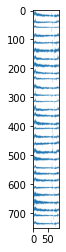

In [20]:
#check training images
plt.figure()
plt.imshow(training_data[0])

print(training_data[0].shape)
plt.savefig('test3.png')

In [21]:
#train build_autoencoder model on the dataset of good and bad spectra
#total training set is 1000 images, 700 "good" and 300 of the "bad" 1 diff and 2 diff images

epochs= 5

#split data
X_train,X_valid,X_test,X_test = train_test_split(training_data, training_data,
                                                             test_size=0.2, random_state=13, 
                                                             shuffle=True)

autoencoder_train = autoencoder.fit(X_train, X_train, epochs=epochs,verbose=1,
    validation_data=(ground_train, ground_train))

# Model evaluation
scores = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

#save weights & model
# autoencoder = autoencoder.save_weights('autoencoder_weights.h5')
# autoencoder.save("autoencoder.h5py")

accuracy = autoencoder_train.history['accuracy']
val_accuracy = autoencoder_train.history['val_accuracy']
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(len(accuracy))
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
ax1.plot(epochs, accuracy, 'r--', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend()
ax2.plot(epochs, loss, 'r--', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()
plt.show()

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3340 - accuracy: 0.5005 - val_loss: 0.3104 - val_accuracy: 0.5044
Epoch 2/10
 901/1875 [=============>................] - ETA: 2s - loss: 0.3052 - accuracy: 0.5065

KeyboardInterrupt: 

In [ ]:
#visually inspect reconstructions to test accuracy
pred = autoencoder.predict(testX)
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(testX[i, ..., 0], cmap='gray')
    curr_lbl = testX[i]
    #plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()